<a href="https://colab.research.google.com/github/vngeno/E-COMMERCE-RECOMMENDATION-SYSTEM-/blob/Collaborative-Based-Filtering/Collaborative_Recommend_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Peak into the dataset

In [1]:
!pip install wandb

     |████████████████████████████████| 1.7 MB 5.1 MB/s 
     |████████████████████████████████| 180 kB 57.2 MB/s 
     |████████████████████████████████| 139 kB 53.3 MB/s 
     |████████████████████████████████| 97 kB 6.9 MB/s 
     |████████████████████████████████| 63 kB 1.9 MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-py3-none-any.whl size=6502 sha256=167b91171cf12626c9d71ce9dcd7b91f2bc5f7915bce0ca7c19d95f2989f7044
  Stored in directory: /root/.cache/pip/wheels/50/ca/fa/8fca8d246e64f19488d07567547ddec8eb084e8c0d7a59226a
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8807 sha256=bc254ba7ba06ca4bced7dc24f1ee1de6ba8fd1234086949cf5187f9ebcfe3b39
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built subprocess32 pathtools


In [2]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [3]:
wandb.init(project='pythoncollaborative',
           entity='team-stars-project',
           save_code= True,name="Collaborative_Keras",
           config={"architecture":"Keras",
           "dataset":"Datafiniti Amazon Consumer Reviews"})

# 2. Save model inputs and hyperparameters
config = wandb.config
config.learning_rate = 0.01

wandb: Currently logged in as: jack-analyst (use `wandb login --relogin` to force relogin)


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
#load the datasets
df = pd.read_csv("/content/drive/Shareddrives/Team Stars/Data/df_clean.csv",index_col=0)
df.head()

,id,name,brand,primarycategories,manufacturernumber,reviews_dorecommend,reviews_numhelpful,reviews_rating,reviews_text,reviews_title,reviews_username
0,AVpgNzjwLJeJML43Kpxn,AmazonBasics AAA Performance Alkaline Batterie...,Amazonbasics,Health & Beauty,HL-002619,True,1.0,3,I order 3 of them and one of the item is bad q...,... 3 of them and one of the item is bad quali...,Byger yang
1,AVpgNzjwLJeJML43Kpxn,AmazonBasics AAA Performance Alkaline Batterie...,Amazonbasics,Health & Beauty,HL-002619,True,1.0,4,Bulk is always the less expensive way to go fo...,... always the less expensive way to go for pr...,ByMG
2,AVpgNzjwLJeJML43Kpxn,AmazonBasics AAA Performance Alkaline Batterie...,Amazonbasics,Health & Beauty,HL-002619,True,1.0,5,Well they are not Duracell but for the price i...,... are not Duracell but for the price i am ha...,BySharon Lambert
3,AVpgNzjwLJeJML43Kpxn,AmazonBasics AAA Performance Alkaline Batterie...,Amazonbasics,Health & Beauty,HL-002619,True,1.0,5,Seem to work as well as name brand batteries a...,... as well as name brand batteries at a much ...,Bymark sexson
4,AVpgNzjwLJeJML43Kpxn,AmazonBasics AAA Performance Alkaline Batterie...,Amazonbasics,Health & Beauty,HL-002619,True,1.0,5,These batteries are very long lasting the pric...,... batteries are very long lasting the price ...,Bylinda


In [7]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
dataset=df[['id','reviews_username','reviews_rating']]
dataset.id=le.fit_transform(dataset.id)
dataset.reviews_username=le.fit_transform(dataset.reviews_username)
dataset=dataset.rename(columns={'reviews_username':'user_id','id':'item_id','reviews_rating':'rating'})
dataset.head()

,item_id,user_id,rating
0,21,8417,3
1,21,5201,4
2,21,6994,5
3,21,8769,5
4,21,8713,5


So, each record (row) shows the rating for a user, item (movie) pair. It should be noted that I use  item and movie interchangeably in this post.

In [8]:
len(dataset.user_id.unique()), len(dataset.item_id.unique())

(16269, 65)

We assign a unique number between (0, #users) to each user and do the same for movies.

In [9]:
dataset.user_id = dataset.user_id.astype('category').cat.codes.values
dataset.item_id = dataset.item_id.astype('category').cat.codes.values

In [10]:
dataset.head()

,item_id,user_id,rating
0,21,8417,3
1,21,5201,4
2,21,6994,5
3,21,8769,5
4,21,8713,5


### Train test split

We'll now split our dataset of product ratings into train and test. Given the train set, we'd like to accurately estimate the ratings in the test set.

In [11]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(dataset, test_size=0.2)

In [12]:
train.head()

,item_id,user_id,rating
13922,34,11047,5
7762,21,5221,2
8144,21,9075,5
3169,21,3912,5
18654,22,11544,5


In [13]:
test.head()

,item_id,user_id,rating
10012,7,997,5
22348,32,14476,5
16519,34,13445,4
10554,7,1151,5
18475,22,9505,5


### Matrix factorisation

One popular recommender systems approach is called Matrix Factorisation. It works on the principle that we can learn a low-dimensional representation (embedding) of user and movie. For example, for each movie, we can have how much action it has, how long it is, and so on. For each user, we can encode how much they like action, or how much they like long movies, etc. Thus, we can combine the user and the movie embeddings to estimate the ratings on unseen movies. This approach can also be viewed as: given a matrix (A [M X N]) containing users and movies, we want to estimate low dimensional matrices (W [M X k] and H [M X k]), such that: $A \approx W.H^T$

### Matrix factorisation in Keras

We'll now write some code to solve the recommendation problem by matrix factorisation in Keras. We're trying to learn two low-dimensional embeddings of users and items.




In [14]:
import keras
from IPython.display import SVG
from keras import optimizers
from keras.utils.vis_utils import model_to_dot
n_users, n_product = len(dataset.user_id.unique()), len(dataset.item_id.unique())
n_latent_factors = 3

The key thing is to learn an embedding for movies and users, and then combine them using the dot product! For estimating the rating, for each user, movie pair of interest, we'd take the dot product of the respective user and item embedding. As an example, if we have 2 dimensions in our user and item embedding, which say correspond to [how much user likes action, how much user likes long movies], and the item embedding is [how much action is in the movie, how long is the movie]. Then, we can predict for a user `u`, and movie `m` as how much `u` likes action $\times$ how much action is there in `m` $+$ how much `u` likes long movies $\times$ how long is `m`.

Our model would optimise the emebedding such that we minimise the mean squared error on the ratings from the train set.

In [15]:
product_input = keras.layers.Input(shape=[1],name='Item')
product_embedding = keras.layers.Embedding(n_product + 1, n_latent_factors, name='product-Embedding')(product_input)
product_vec = keras.layers.Flatten(name='Flattenproducts')(product_embedding)

user_input = keras.layers.Input(shape=[1],name='User')
user_embedding=keras.layers.Embedding(n_users + 1, n_latent_factors,name='User-Embedding')(user_input)
user_vec = keras.layers.Flatten(name='FlattenUsers')(user_embedding)
from keras.layers import Input, Embedding, Flatten, Dot, Dense
from keras.models import Model
# prod = Dot(name="Dot-Product", axes=1)([product_vec, user_vec])
# prod = keras.layers.merge([product_vec, user_vec], mode='dot',name='DotProduct')
prod = keras.layers.merge.dot([product_vec, user_vec],axes=1,name='DotProduct')
model = keras.Model([user_input, product_input], prod)
model.compile('adam', 'mean_squared_error')

Here's a visualisation of our model for a better understanding.

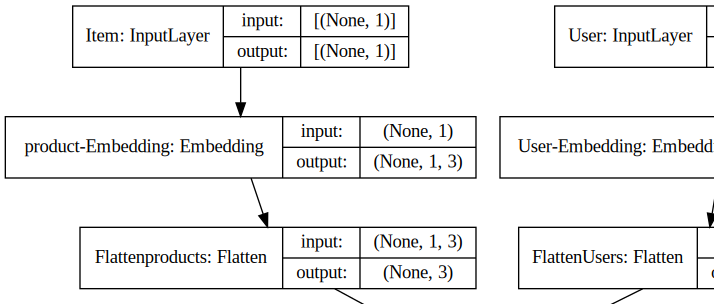

In [16]:
SVG(model_to_dot(model,  show_shapes=True, show_layer_names=True, rankdir='HB').create(prog='dot', format='svg'))

We can see that in the `Merge` layer, we take the dot product of the user and the item embeddings to obtain the rating.

We can also summarise our model as follows:

In [17]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
User (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
product-Embedding (Embedding)   (None, 1, 3)         198         Item[0][0]                       
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 3)         48810       User[0][0]                       
______________________________________________________________________________________________

So, we have 7881 parameters to learn! Let's train our model now!

In [18]:
from wandb.keras import WandbCallback
history = model.fit([train.user_id, train.item_id], train.rating, epochs=25,validation_split=0.1, verbose=1,callbacks=[WandbCallback()])
wandb.finish()

Epoch 1/25
638/638 [==============================] - 2s 2ms/step - loss: 21.1557 - val_loss: 20.8576
Epoch 2/25
638/638 [==============================] - 1s 2ms/step - loss: 20.2780 - val_loss: 19.9479
Epoch 3/25
638/638 [==============================] - 1s 2ms/step - loss: 18.5556 - val_loss: 18.7839
Epoch 4/25
638/638 [==============================] - 1s 2ms/step - loss: 16.1038 - val_loss: 17.2744
Epoch 5/25
638/638 [==============================] - 1s 2ms/step - loss: 13.1481 - val_loss: 15.6778
Epoch 6/25
638/638 [==============================] - 1s 2ms/step - loss: 10.1695 - val_loss: 14.2330
Epoch 7/25
638/638 [==============================] - 1s 2ms/step - loss: 7.5280 - val_loss: 13.0176
Epoch 8/25
638/638 [==============================] - 1s 2ms/step - loss: 5.3888 - val_loss: 12.0759
Epoch 9/25
638/638 [==============================] - 1s 2ms/step - loss: 3.7829 - val_loss: 11.3564
Epoch 10/25
638/638 [==============================] - 1s 2ms/step - loss: 2.6480 - v

best_epoch,24
best_val_loss,9.83216
epoch,24
loss,0.21835
val_loss,9.83216


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,██▇▆▅▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▇▆▅▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


#### Train error v/s epoch number

Before we test how well our model does in the test setting, we can visualise the train loss with epoch number.

Text(0, 0.5, 'Train Error')

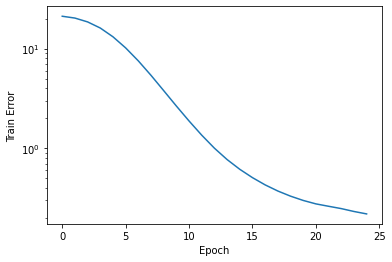

In [19]:
pd.Series(history.history['loss']).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Train Error")

#### Prediction error

Let's now see how our model does! I'll do a small post-processing step to round off our prediction to the nearest integer. This is usually not done, and thus just a whimsical step, since the training ratings are all integers! There are better ways to encode this intger requirement (one-hot encoding!), but we won't discuss them in this post.

In [20]:
y_hat = np.round(model.predict([test.user_id, test.item_id]),0)
y_true = test.rating

In [21]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_true, y_hat)

2.211928710075878

In [22]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_true, y_hat)

10.073936827245456

In [23]:
np.sqrt(mean_squared_error(y_true, y_hat))

3.1739465696897695

Not bad! We're able to get a $MAE$ of 0.69! I'm sure with a bit of parameter/hyper-parameter optimisation, we may be able to improve the results. However, I won't talk about these optimisations in this post. 

#### Extracting the learnt embeddings

We can extract the learnt movie and item embeddings as follows:

In [24]:
product_embedding_learnt = model.get_layer(name='product-Embedding').get_weights()[0]
pd.DataFrame(product_embedding_learnt).describe()

,0,1,2
count,66.000000,66.000000,66.000000
mean,-1.208102,0.451010,-1.707956
std,2.672604,2.926196,2.465389
min,-6.642188,-5.990523,-6.654827
25%,-3.590393,-1.912434,-4.154700
50%,-0.947653,0.702595,-1.089036
75%,0.750205,1.887218,0.572430
max,5.982556,5.815598,2.420029


In [25]:
user_embedding_learnt = model.get_layer(name='User-Embedding').get_weights()[0]
pd.DataFrame(user_embedding_learnt).describe()

,0,1,2
count,16270.000000,16270.000000,16270.000000
mean,-0.002926,-0.037676,-0.219458
std,0.280571,0.273728,0.183016
min,-1.019973,-0.661989,-1.057570
25%,-0.307285,-0.274612,-0.323990
50%,0.024496,-0.049514,-0.271932
75%,0.263100,0.271701,-0.105041
max,1.083385,1.056127,0.634911


We can see that both the user and the item embeddings have negative elements. There are some applications which require that the learnt embeddings be non-negative. This approach is also called non-negative matrix factorisation, which we'll workout now.

### Neural networks for recommendation

We'll now create a simple neural network for recommendation, or for estimating rating! This model is very similar to the earlier matrix factorisation models, but differs in the following ways:

1. Instead of taking a dot product of the user and the item embedding, we concatenate them and use them as features for our neural network. Thus, we are not constrained to the dot product way of combining the embeddings, and can learn complex non-linear relationships.
2. Due to #1, we can now have a different dimension of user and item embeddings. This can be useful if one dimension is larger than the other.

In [29]:
n_latent_factors_user = 5
n_latent_factors_product = 8

product_input = keras.layers.Input(shape=[1],name='Item')
product_embedding = keras.layers.Embedding(n_product + 1, n_latent_factors_product, name='product-Embedding')(product_input)
product_vec = keras.layers.Flatten(name='Flattenproducts')(product_embedding)
product_vec = keras.layers.Dropout(0.2)(product_vec)


user_input = keras.layers.Input(shape=[1],name='User')
user_vec = keras.layers.Flatten(name='FlattenUsers')(keras.layers.Embedding(n_users + 1, n_latent_factors_user,name='User-Embedding')(user_input))
user_vec = keras.layers.Dropout(0.2)(user_vec)


concat = keras.layers.merge.concatenate([product_vec, user_vec],name='Concat')
concat_dropout = keras.layers.Dropout(0.2)(concat)
dense = keras.layers.Dense(200,name='FullyConnected')(concat)
dropout_1 = keras.layers.Dropout(0.2,name='Dropout')(dense)
dense_2 = keras.layers.Dense(100,name='FullyConnected-1')(concat)
dropout_2 = keras.layers.Dropout(0.2,name='Dropout')(dense_2)
dense_3 = keras.layers.Dense(50,name='FullyConnected-2')(dense_2)
dropout_3 = keras.layers.Dropout(0.2,name='Dropout')(dense_3)
dense_4 = keras.layers.Dense(20,name='FullyConnected-3', activation='relu')(dense_3)

from keras import optimizers
result = keras.layers.Dense(1, activation='relu',name='Activation')(dense_4)

model = keras.Model([user_input, product_input], result)
model.compile(optimizer='adam',loss= 'mean_absolute_error')

Let's now see how our model looks like:

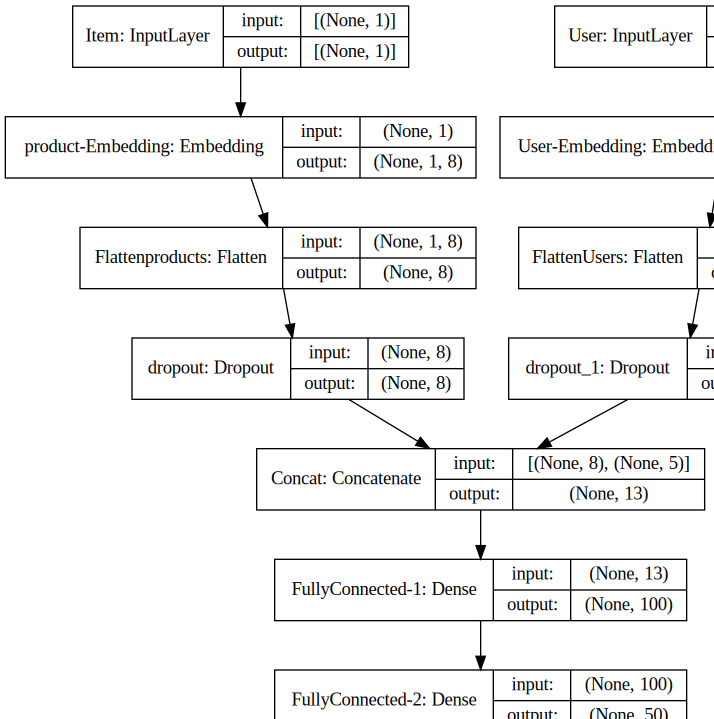

In [30]:
SVG(model_to_dot(model,  show_shapes=True, show_layer_names=True, rankdir='HB').create(prog='dot', format='svg'))

It should be noted that we use a different number of embeddings for user (3) and items (5)! These combine to form a vector of length (5+3 = 8), which is then fed into the neural network. We also add a dropout layer to prevent overfitting!

In [31]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
User (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
product-Embedding (Embedding)   (None, 1, 8)         528         Item[0][0]                       
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 5)         81350       User[0][0]                       
____________________________________________________________________________________________

We can see that the number of parameters is more than what we had in the Matrix Factorisation case. Let's see how this model works. I'll run it for more epochs given that we have more parameters.

In [32]:
wandb.init(project='pythoncollaborative',
           entity='team-stars-project',
           save_code= True,name="Collaborative_Neural_Networks_Keras",
           config={"architecture":"Keras",
           "dataset":"Datafiniti Amazon Consumer Reviews"})

# 2. Save model inputs and hyperparameters
config = wandb.config
config.learning_rate = 0.01

In [33]:
history = model.fit([train.user_id, train.item_id], train.rating, validation_split=0.1, epochs=25, verbose=1,callbacks=[WandbCallback()])
wandb.finish()

Epoch 1/25
638/638 [==============================] - 3s 3ms/step - loss: 0.7357 - val_loss: 0.5231
Epoch 2/25
638/638 [==============================] - 2s 3ms/step - loss: 0.4980 - val_loss: 0.5056
Epoch 3/25
638/638 [==============================] - 2s 3ms/step - loss: 0.4681 - val_loss: 0.5167
Epoch 4/25
638/638 [==============================] - 2s 3ms/step - loss: 0.3936 - val_loss: 0.4799
Epoch 5/25
638/638 [==============================] - 2s 3ms/step - loss: 0.3585 - val_loss: 0.4810
Epoch 6/25
638/638 [==============================] - 2s 3ms/step - loss: 0.2699 - val_loss: 0.4135
Epoch 7/25
638/638 [==============================] - 2s 3ms/step - loss: 0.2341 - val_loss: 0.3965
Epoch 8/25
638/638 [==============================] - 2s 3ms/step - loss: 0.2135 - val_loss: 0.4135
Epoch 9/25
638/638 [==============================] - 2s 3ms/step - loss: 0.2018 - val_loss: 0.4190
Epoch 10/25
638/638 [==============================] - 2s 3ms/step - loss: 0.1919 - val_loss: 0.3904

best_epoch,23
best_val_loss,0.38152
epoch,24
loss,0.16618
val_loss,0.40283


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▅▅▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇█▆▆▃▂▃▃▁▂▂▃▂▁▂▃▂▂▂▃▁▁▁▂


#### Prediction performance of Neural Network based recommender system

In [34]:
y_hat_2 = np.round(model.predict([test.user_id, test.item_id]),0)
print(mean_absolute_error(y_true, y_hat_2))
print(mean_absolute_error(y_true, model.predict([test.user_id, test.item_id])))

0.3536262572789836
0.3948915587839719


Pretty similar to the result we got using matrix factorisation. Maybe, we need to tweak around a lot more with the neural network to get better results?

Thanks for reading. This post has been a good learning experience for me. Hope you enjoyed too! 